In [0]:
import cv2
import numpy as np
import imutils

In [0]:
!wget "https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/vacation-photos/vacation-image-search-engine.zip"

--2019-06-10 13:21:21--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/vacation-photos/vacation-image-search-engine.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.192.216
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.192.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199533981 (190M) [application/zip]
Saving to: ‘vacation-image-search-engine.zip’

vacation-image-sear 100%[===================>] 190.29M  58.1MB/s    in 3.6s    

2019-06-10 13:21:25 (52.5 MB/s) - ‘vacation-image-search-engine.zip’ saved [199533981/199533981]



In [0]:
!unzip "vacation-image-search-engine.zip"

In [0]:
class ColorDescriptor:
	def __init__(self, bins):
		# store the number of bins for the 3D histogram
		self.bins = bins

	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		features = []

		# grab the dimensions and compute the center of the image
		(h, w) = image.shape[:2]
		(cX, cY) = (int(w * 0.5), int(h * 0.5))
		# divide the image into four rectangles/segments (top-left,
		# top-right, bottom-right, bottom-left)
		segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
			(0, cX, cY, h)]

		# construct an elliptical mask representing the center of the
		# image
		(axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
		ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
		cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

		# loop over the segments
		for (startX, endX, startY, endY) in segments:
			# construct a mask for each corner of the image, subtracting
			# the elliptical center from it
			cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
			cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
			cornerMask = cv2.subtract(cornerMask, ellipMask)

			# extract a color histogram from the image, then update the
			# feature vector
			hist = self.histogram(image, cornerMask)
			features.extend(hist)

		# extract a color histogram from the elliptical region and
		# update the feature vector
		hist = self.histogram(image, ellipMask)
		features.extend(hist)

		# return the feature vector
		return features

	def histogram(self, image, mask):
		# extract a 3D color histogram from the masked region of the
		# image, using the supplied number of bins per channel
		hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
			[0, 180, 0, 256, 0, 256])

		hist = cv2.normalize(hist, hist).flatten()

		# return the histogram
		return hist

In [0]:
import glob

In [0]:
# initialize the color descriptor
cd = ColorDescriptor((8, 12, 3))

# open the output index file for writing
output = open("index.csv", "w")

# use glob to grab the image paths and loop over them
for imagePath in glob.glob("/content/vacation-image-search-engine/dataset" + "/*.png"):
	# extract the image ID (i.e. the unique filename) from the image
	# path and load the image itself
	imageID = imagePath[imagePath.rfind("/") + 1:]
	image = cv2.imread(imagePath)

	# describe the image
	features = cd.describe(image)

	# write the features to file
	features = [str(f) for f in features]
	output.write("%s,%s\n" % (imageID, ",".join(features)))

# close the index file
output.close()

In [0]:
import csv

In [0]:
class Searcher:
	def __init__(self, indexPath):
		# store our index path
		self.indexPath = indexPath

	def search(self, queryFeatures, limit = 10):
		# initialize our dictionary of results
		results = {}

		# open the index file for reading
		with open(self.indexPath) as f:
			# initialize the CSV reader
			reader = csv.reader(f)

			# loop over the rows in the index
			for row in reader:
				# parse out the image ID and features, then compute the
				# chi-squared distance between the features in our index
				# and our query features
				features = [float(x) for x in row[1:]]
				d = self.chi2_distance(features, queryFeatures)
				results[row[0]] = d 

			# close the reader
			f.close()

		# sort our results, so that the smaller distances (i.e. the
		# more relevant images are at the front of the list)
		results = sorted([(v, k) for (k, v) in results.items()])

		# return our (limited) results
		return results[:limit]

	def chi2_distance(self, histA, histB, eps = 1e-10):
		# compute the chi-squared distance
		d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
			for (a, b) in zip(histA, histB)])

		# return the chi-squared distance
		return d

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
!cd /content

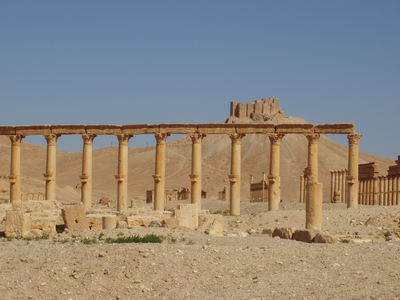

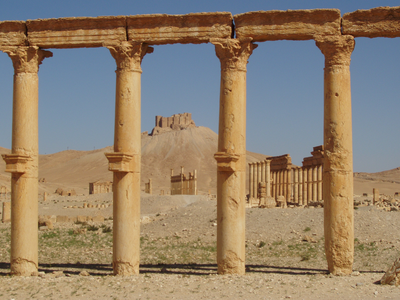

In [0]:
cd = ColorDescriptor((8, 12, 3))

# load the query image and describe it
query = cv2.imread("/content/vacation-image-search-engine/queries/115100.png")
features = cd.describe(query)

# perform the search
searcher = Searcher("index.csv")
results = searcher.search(features, 1)

# display the query
cv2_imshow(query)

# loop over the results
for (score, resultID) in results:
	# load the result image and display it
	result = cv2.imread("/content/vacation-image-search-engine/dataset/" + resultID)
	cv2_imshow(result)
	cv2.waitKey(0)
  

In [0]:
score

2.636241594879476